# Bank Churn

**Objetivo principal**: predecir si un cliente del banco acabará cancelando su cuenta y dejando de ser cliente.

# Librerías

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

from imblearn.under_sampling import RandomUnderSampler, TomekLinks, InstanceHardnessThreshold
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE, BorderlineSMOTE

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

import warnings
warnings.filterwarnings('ignore')

# Análisis Exploratorio

In [2]:
df = pd.read_csv('./Churn_Modelling.csv', index_col=0)

In [3]:
df.reset_index(drop=True, inplace=True)

In [4]:
df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [5]:
df.shape

(10000, 13)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           10000 non-null  int64  
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 898.5+ KB


In [7]:
df['Geography'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

In [8]:
df['Gender'].value_counts()

Male      5457
Female    4543
Name: Gender, dtype: int64

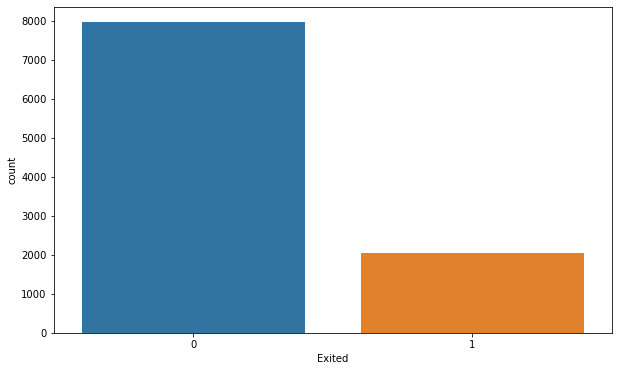

In [9]:
plt.rcParams['figure.figsize'] = (10,6)
_ = sns.countplot(df['Exited'])

In [10]:
df.isna().sum()

CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [11]:
len(df[(df['Balance'] == 0) & (df['Exited'] == 0)])

3117

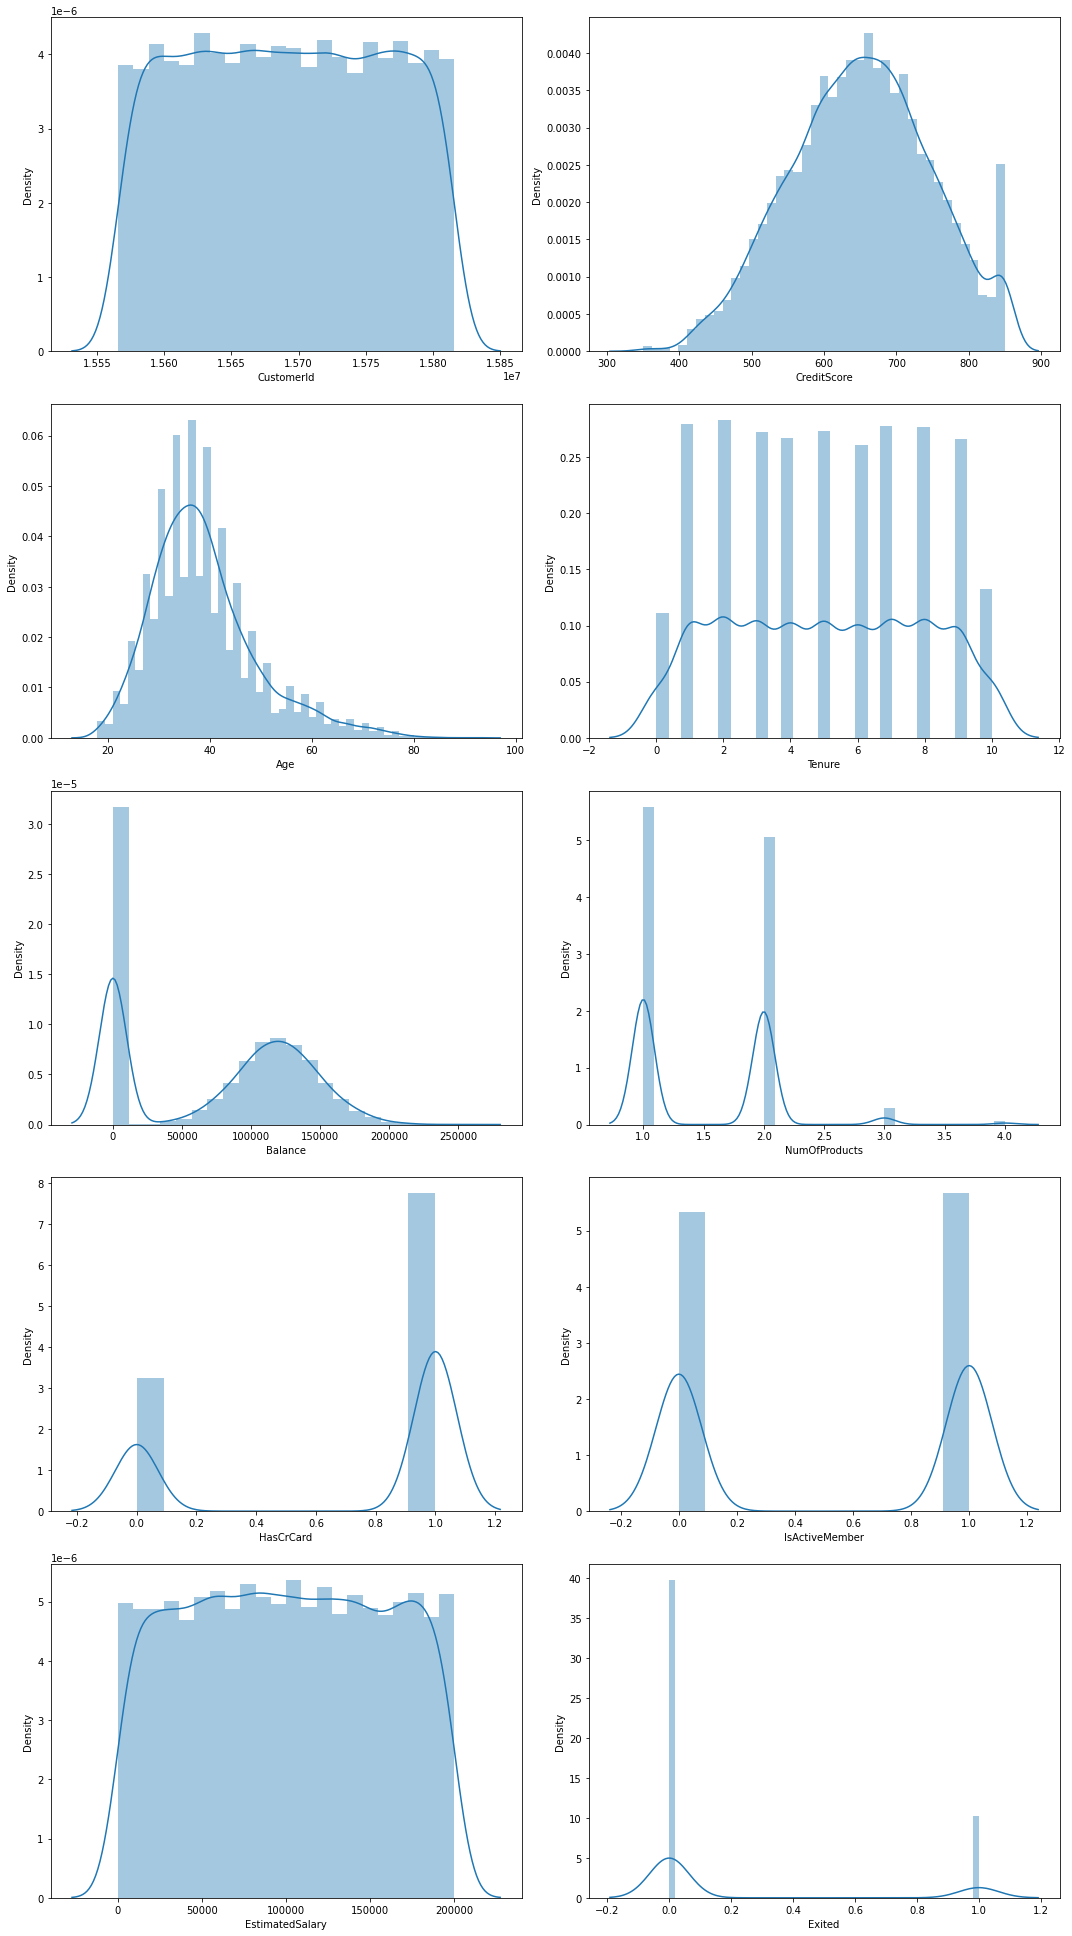

In [12]:
fig, ax = plt.subplots(5,2, figsize=(15,27))
var = df.select_dtypes(include='number').columns.to_list()

for i in range(5):
    for j in range(2):
        x = var.pop(0) # Con .pop() extrae el primer valor de la lista y nos ahorramos otra iteración
        sns.distplot(df[x], ax=ax[i][j])
        
fig.tight_layout()

In [13]:
df.drop(['CustomerId', 'Surname'], axis=1, inplace=True)

In [14]:
df = pd.get_dummies(df, drop_first=True)

In [15]:
# Reordenamos las columnas para que quede 'Exited' al final:

df = df[['CreditScore',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary',
 'Geography_Germany',
 'Geography_Spain',
 'Gender_Male',
 'Exited']]

Tras hacer encoding de las variables categóricas, este es el dataframe final con el que continuar.

In [16]:
df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male,Exited
0,619,42,2,0.00,1,1,1,101348.88,0,0,0,1
1,608,41,1,83807.86,1,0,1,112542.58,0,1,0,0
2,502,42,8,159660.80,3,1,0,113931.57,0,0,0,1
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,1,0,0


In [17]:
df.corr()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male,Exited
CreditScore,1.000000,-0.003965,0.000842,0.006268,0.012238,-0.005458,0.025651,-0.001384,0.005538,0.004780,-0.002857,-0.027094
Age,-0.003965,1.000000,-0.009997,0.028308,-0.030680,-0.011721,0.085472,-0.007201,0.046897,-0.001685,-0.027544,0.285323
Tenure,0.000842,-0.009997,1.000000,-0.012254,0.013444,0.022583,-0.028362,0.007784,-0.000567,0.003868,0.014733,-0.014001
Balance,0.006268,0.028308,-0.012254,1.000000,-0.304180,-0.014858,-0.010084,0.012797,0.401110,-0.134892,0.012087,0.118533
NumOfProducts,0.012238,-0.030680,0.013444,-0.304180,1.000000,0.003183,0.009612,0.014204,-0.010419,0.009039,-0.021859,-0.047820
HasCrCard,-0.005458,-0.011721,0.022583,-0.014858,0.003183,1.000000,-0.011866,-0.009933,0.010577,-0.013480,0.005766,-0.007138
IsActiveMember,0.025651,0.085472,-0.028362,-0.010084,0.009612,-0.011866,1.000000,-0.011421,-0.020486,0.016732,0.022544,-0.156128
EstimatedSalary,-0.001384,-0.007201,0.007784,0.012797,0.014204,-0.009933,-0.011421,1.000000,0.010297,-0.006482,-0.008112,0.012097
Geography_Germany,0.005538,0.046897,-0.000567,0.401110,-0.010419,0.010577,-0.020486,0.010297,1.000000,-0.332084,-0.024628,0.173488
Geography_Spain,0.004780,-0.001685,0.003868,-0.134892,0.009039,-0.013480,0.016732,-0.006482,-0.332084,1.000000,0.016889,-0.052667


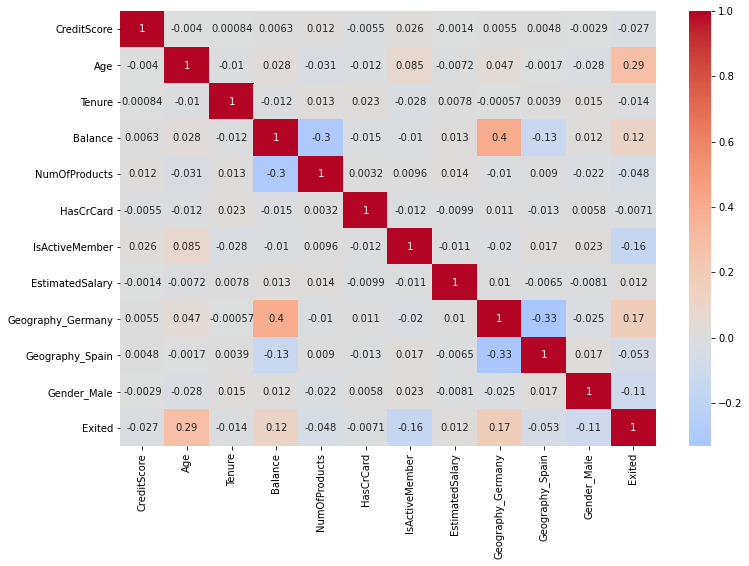

In [18]:
plt.rcParams['figure.figsize'] = (12,8)
_ = sns.heatmap(df.corr(), annot=True, cmap='coolwarm', center=0)

In [19]:
# Definimos X e y

X = df.drop('Exited', axis=1)
y = df['Exited']

# Clustering y Reducción de la Dimensionalidad

In [20]:
def clustering(dataframe, scaler=StandardScaler(), modelo_red=PCA(), modelo_clust=KMeans(5, random_state=42)):
    data_scaled = scaler.fit_transform(dataframe)
    cl = modelo_clust
    cl.fit(data_scaled)
    dataframe['Labels'] = cl.fit(data_scaled).labels_
    pc = modelo_red.fit_transform(dataframe)
    test = pd.DataFrame(pc[:,:2], columns=['t1', 't2'])
    test['lb'] = df['Labels'].apply(lambda x: str(x))
    fig, axs = plt.subplots(ncols=2, figsize=(20,10))
    vis1 = sns.scatterplot(data=test, x='t1', y='t2', hue=y, ax=axs[0])
    vis2 = sns.scatterplot(data=test, x='t1', y='t2', hue='lb', ax=axs[1])

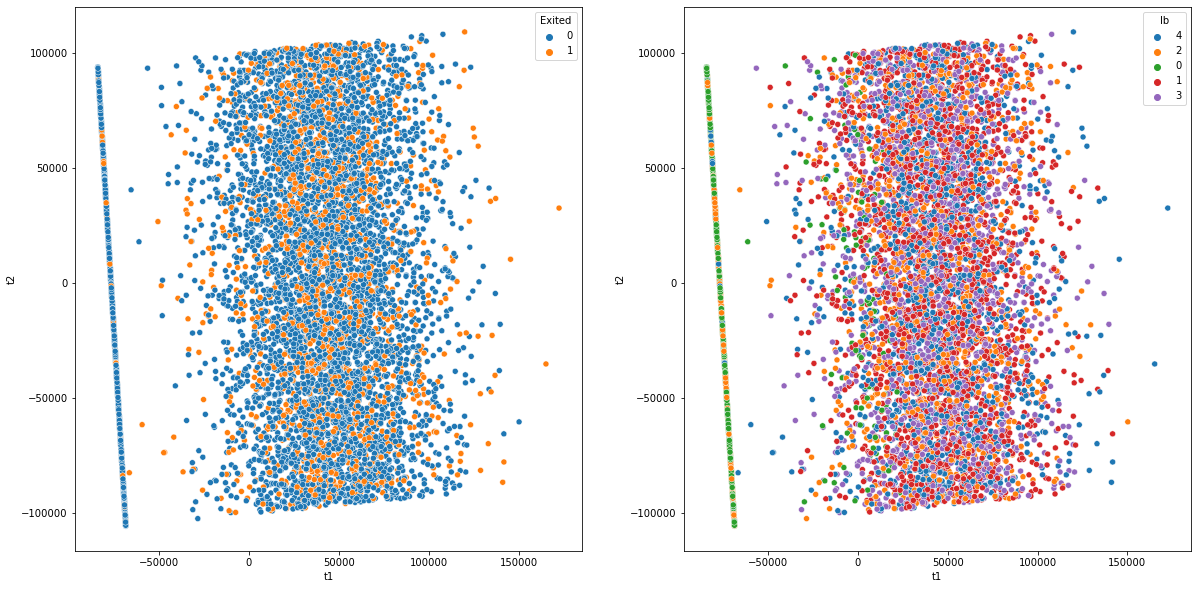

In [21]:
# StandardScaler
# PCA
# KMeans
clustering(dataframe=df)

Hemos seleccionado 5 clusters tras comprobar las inercias:

In [22]:
inertias = [KMeans(k).fit(StandardScaler().fit_transform(df)).inertia_ for k in range(2,10)]
inertias

[110313.36167002862,
 100281.36610973021,
 92372.74484219574,
 86749.93500509723,
 83879.61464317353,
 81560.1683905571,
 78682.881557944,
 76839.63931494024]

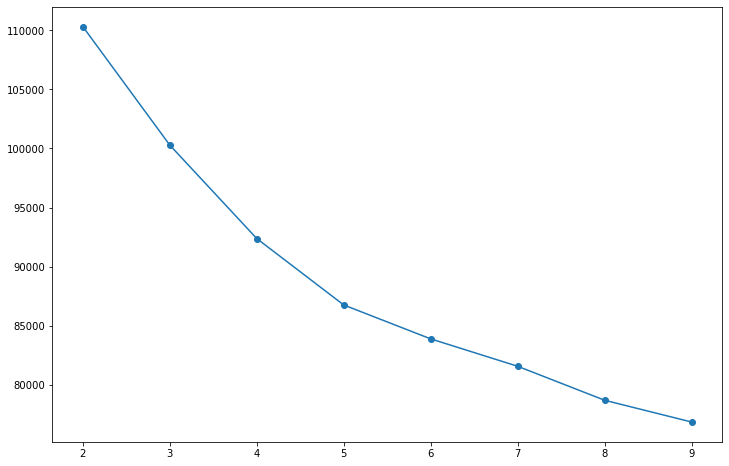

In [23]:
_ = plt.plot(range(2,10), inertias, marker='o')

También probamos otras combinaciones cambiando los parámetros de la función que hemos creado, pero el mejor resultado nos quedó con el KMeans de 5 clusters mostrado arriba.

In [24]:
# StandardScaler
# PCA
# KMeans con 8 k
# clustering(dataframe=df, modelo_clust=KMeans(8, random_state=42))

In [25]:
# StandardScaler
# TSNE
# KMeans
# clustering(dataframe=df, modelo_red=TSNE())

In [26]:
# StandardScaler
# TSNE
# KMeans = 8 k
# clustering(dataframe=df, modelo_red=TSNE(), modelo_clust=KMeans(8, random_state=42))

In [27]:
# StandardScaler
# PCA
# DBSCAN

# Test 1: Logistic Regression

In [28]:
def logreg(X,y,test_size=0.3):
    """
    Ejecuta un modelo logistic regression a partir de una X y una variable objetivo y.
    Se le puede inputar el test_size, que inicialmente será 0.3
    Imprime la classification report.
    """
    X_train, X_test, y_train,y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    lr = LogisticRegression(max_iter=10000)
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    print(f'Classification report usando {lr}\n')
    print(classification_report(y_test, y_pred))

**Función:** ejecuta un modelo de logistic regression a partir de la X e y definidas inicialmente e imprime el classification report.

In [29]:
logreg(X,y)

Classification report usando LogisticRegression(max_iter=10000)

              precision    recall  f1-score   support

           0       0.81      0.97      0.89      2416
           1       0.44      0.08      0.14       584

    accuracy                           0.80      3000
   macro avg       0.63      0.53      0.51      3000
weighted avg       0.74      0.80      0.74      3000



Evidentemente, nuestra precisión para la variable que queremos predecir es muy baja por no haber preprocesado los datos.

# Test 2: Data scaling + Logistic Regression

Creamos una nueva función basándonos en la anterior pero esta vez añadiendo el escalado.

In [30]:
def logregscaled(X,y,test_size=0.3, scaler=StandardScaler()):
    """
    Ejecuta un modelo logistic regression a partir de una X y una variable objetivo y.
    Se le puede inputar el test_size, que inicialmente será 0.3
    Imprime la classification report.
    """
    
    model = scaler
    X_scaled = model.fit_transform(X)
    
    X_train, X_test, y_train,y_test = train_test_split(X_scaled, y, test_size=test_size, random_state=42)
    
    lr = LogisticRegression(max_iter=10000)
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    print(f'Classification report usando {scaler} y {lr}\n')
    print(classification_report(y_test, y_pred))

### Standard Scaler

In [31]:
logregscaled(X,y)

Classification report usando StandardScaler() y LogisticRegression(max_iter=10000)

              precision    recall  f1-score   support

           0       0.83      0.96      0.89      2416
           1       0.54      0.20      0.29       584

    accuracy                           0.81      3000
   macro avg       0.69      0.58      0.59      3000
weighted avg       0.78      0.81      0.77      3000



El recall de nuestra variable objetivo ya ha subido considerablemente solo con el escalado.

Probamos distintos scalers pero el que mejor resultado nos dió fue el StandardScaler

### Max Abs

In [32]:
logregscaled(X,y,test_size=0.3,  scaler=MaxAbsScaler())

Classification report usando MaxAbsScaler() y LogisticRegression(max_iter=10000)

              precision    recall  f1-score   support

           0       0.83      0.97      0.89      2416
           1       0.57      0.19      0.29       584

    accuracy                           0.81      3000
   macro avg       0.70      0.58      0.59      3000
weighted avg       0.78      0.81      0.78      3000



### Robust

In [33]:
logregscaled(X,y,test_size=0.3,  scaler=RobustScaler(quantile_range = (0.1, 0.9)))

Classification report usando RobustScaler(quantile_range=(0.1, 0.9)) y LogisticRegression(max_iter=10000)

              precision    recall  f1-score   support

           0       0.87      0.77      0.82      2416
           1       0.36      0.54      0.44       584

    accuracy                           0.73      3000
   macro avg       0.62      0.66      0.63      3000
weighted avg       0.78      0.73      0.74      3000



### Min max

In [34]:
logregscaled(X,y,test_size=0.3,  scaler=MinMaxScaler())

Classification report usando MinMaxScaler() y LogisticRegression(max_iter=10000)

              precision    recall  f1-score   support

           0       0.83      0.96      0.89      2416
           1       0.56      0.19      0.29       584

    accuracy                           0.81      3000
   macro avg       0.70      0.58      0.59      3000
weighted avg       0.78      0.81      0.77      3000



# Test 3: Logistic Regression + Scaling + Oversampling

Volvemos a crear una nueva función basada en la anterior con el escalador, añadiendo el oversampling.

In [35]:
def logregscaled_resampled(X,y,test_size=0.3, scaler=StandardScaler(), resampler=SMOTETomek()):
    """
    Ejecuta un modelo logistic regression a partir de una X y una variable objetivo y.
    Se le puede inputar el test_size, que inicialmente será 0.3
    Imprime la classification report.
    """
    
    resampling_method = resampler
    X_res, y_res = resampling_method.fit_resample(X,y)
    
    model = scaler
    X_scaled = model.fit_transform(X_res)
    
    X_train, X_test, y_train,y_test = train_test_split(X_scaled, y_res, test_size=test_size, random_state=42)
    
    lr = LogisticRegression(max_iter=10000)
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    print(f'Classification report usando {scaler}, {lr} y {resampler}\n')
    print(classification_report(y_test, y_pred))

In [36]:
logregscaled_resampled(X,y,test_size=0.3, scaler=RobustScaler(), resampler=SMOTETomek())

Classification report usando RobustScaler(), LogisticRegression(max_iter=10000) y SMOTETomek()

              precision    recall  f1-score   support

           0       0.80      0.78      0.79      2061
           1       0.79      0.80      0.79      2070

    accuracy                           0.79      4131
   macro avg       0.79      0.79      0.79      4131
weighted avg       0.79      0.79      0.79      4131



In [37]:
logregscaled_resampled(X,y,test_size=0.3, scaler=RobustScaler(), resampler=BorderlineSMOTE())

Classification report usando RobustScaler(), LogisticRegression(max_iter=10000) y BorderlineSMOTE()

              precision    recall  f1-score   support

           0       0.79      0.78      0.79      2426
           1       0.78      0.79      0.78      2352

    accuracy                           0.78      4778
   macro avg       0.78      0.78      0.78      4778
weighted avg       0.78      0.78      0.78      4778



In [38]:
logregscaled_resampled(X,y,test_size=0.3, scaler=StandardScaler(), resampler=BorderlineSMOTE())

Classification report usando StandardScaler(), LogisticRegression(max_iter=10000) y BorderlineSMOTE()

              precision    recall  f1-score   support

           0       0.80      0.78      0.79      2426
           1       0.78      0.80      0.79      2352

    accuracy                           0.79      4778
   macro avg       0.79      0.79      0.79      4778
weighted avg       0.79      0.79      0.79      4778



In [39]:
logregscaled_resampled(X,y,test_size=0.3, scaler=StandardScaler(), resampler=SMOTETomek())

Classification report usando StandardScaler(), LogisticRegression(max_iter=10000) y SMOTETomek()

              precision    recall  f1-score   support

           0       0.78      0.77      0.78      2058
           1       0.77      0.78      0.78      2047

    accuracy                           0.78      4105
   macro avg       0.78      0.78      0.78      4105
weighted avg       0.78      0.78      0.78      4105



In [40]:
logregscaled_resampled(X,y,test_size=0.3, scaler=StandardScaler(), resampler=SMOTE())

Classification report usando StandardScaler(), LogisticRegression(max_iter=10000) y SMOTE()

              precision    recall  f1-score   support

           0       0.79      0.78      0.78      2426
           1       0.77      0.79      0.78      2352

    accuracy                           0.78      4778
   macro avg       0.78      0.78      0.78      4778
weighted avg       0.78      0.78      0.78      4778



El recall ha subido mucho al haber aplicado el oversampling solo con el escalado.

Probamos distintos métodos pero el que mejor resultado nos dió fue el SMOTE

In [41]:
logregscaled_resampled(X,y,test_size=0.3, scaler=StandardScaler(), resampler=TomekLinks())

Classification report usando StandardScaler(), LogisticRegression(max_iter=10000) y TomekLinks()

              precision    recall  f1-score   support

           0       0.82      0.95      0.88      2097
           1       0.63      0.27      0.38       615

    accuracy                           0.80      2712
   macro avg       0.72      0.61      0.63      2712
weighted avg       0.77      0.80      0.77      2712



# Test 4: Clasificadores + Resampling + Oversampling

De nuevo, continuamos ampliando la función previa, esta vez especificando el clasificador.

In [42]:
def logregscaled_resampled_classif(X,y,test_size=0.3,classif=LogisticRegression(), scaler=StandardScaler(), resampler=SMOTE()):
    """
    Ejecuta un modelo eligiendo el clasificador, el escalador y el resampler
    a partir de una X y una variable objetivo y.
    Se le puede inputar el test_size, que inicialmente será 0.3
    Imprime la classification report.
    """
    resampling_method = resampler
    X_res, y_res = resampling_method.fit_resample(X,y)
    
    model = scaler
    X_scaled = model.fit_transform(X_res)
    
    X_train, X_test, y_train,y_test = train_test_split(X_scaled, y_res, test_size=test_size, random_state=42)
    
    clas = classif
    clas.fit(X_train, y_train)
    y_pred_test = clas.predict(X_test)
    y_pred_train = clas.predict(X_train)
    
    if classif == DecisionTreeClassifier() or classif == RandomForestClassifier():
        print(clas.feature_importances_)
    
    print(f'Classification report usando {classif}, {scaler} y {resampler}\n')
    print('Fit con Train y predict con Test\n')
    print(classification_report(y_test, y_pred_test))
    print('Fit con Train y predict con Train\n')
    print(classification_report(y_train, y_pred_train))

In [43]:
logregscaled_resampled_classif(X,y)

Classification report usando LogisticRegression(), StandardScaler() y SMOTE()

Fit con Train y predict con Test

              precision    recall  f1-score   support

           0       0.80      0.77      0.79      2426
           1       0.77      0.80      0.79      2352

    accuracy                           0.79      4778
   macro avg       0.79      0.79      0.79      4778
weighted avg       0.79      0.79      0.79      4778

Fit con Train y predict con Train

              precision    recall  f1-score   support

           0       0.79      0.77      0.78      5537
           1       0.78      0.80      0.79      5611

    accuracy                           0.78     11148
   macro avg       0.78      0.78      0.78     11148
weighted avg       0.78      0.78      0.78     11148



In [44]:
logregscaled_resampled_classif(X,y, classif=DecisionTreeClassifier())

Classification report usando DecisionTreeClassifier(), StandardScaler() y SMOTE()

Fit con Train y predict con Test

              precision    recall  f1-score   support

           0       0.80      0.76      0.78      2426
           1       0.77      0.80      0.79      2352

    accuracy                           0.78      4778
   macro avg       0.78      0.78      0.78      4778
weighted avg       0.78      0.78      0.78      4778

Fit con Train y predict con Train

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5537
           1       1.00      1.00      1.00      5611

    accuracy                           1.00     11148
   macro avg       1.00      1.00      1.00     11148
weighted avg       1.00      1.00      1.00     11148



In [45]:
logregscaled_resampled_classif(X,y, classif=RandomForestClassifier())

Classification report usando RandomForestClassifier(), StandardScaler() y SMOTE()

Fit con Train y predict con Test

              precision    recall  f1-score   support

           0       0.86      0.85      0.86      2426
           1       0.85      0.86      0.85      2352

    accuracy                           0.85      4778
   macro avg       0.85      0.85      0.85      4778
weighted avg       0.85      0.85      0.85      4778

Fit con Train y predict con Train

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5537
           1       1.00      1.00      1.00      5611

    accuracy                           1.00     11148
   macro avg       1.00      1.00      1.00     11148
weighted avg       1.00      1.00      1.00     11148



El recall ha vuelto ha mejorar seleccionando RandomForest como clasificador.

In [46]:
clf = MLPClassifier(solver='adam',
                    max_iter=1000,
                    alpha=1e-3,
                    activation='relu', 
                    hidden_layer_sizes=(7,7,3))

In [47]:
logregscaled_resampled_classif(X,y, classif=clf)

Classification report usando MLPClassifier(alpha=0.001, hidden_layer_sizes=(7, 7, 3), max_iter=1000), StandardScaler() y SMOTE()

Fit con Train y predict con Test

              precision    recall  f1-score   support

           0       0.83      0.83      0.83      2426
           1       0.83      0.82      0.82      2352

    accuracy                           0.83      4778
   macro avg       0.83      0.83      0.83      4778
weighted avg       0.83      0.83      0.83      4778

Fit con Train y predict con Train

              precision    recall  f1-score   support

           0       0.83      0.85      0.84      5537
           1       0.85      0.82      0.83      5611

    accuracy                           0.83     11148
   macro avg       0.84      0.83      0.83     11148
weighted avg       0.84      0.83      0.83     11148



In [48]:
logregscaled_resampled_classif(X,y, classif=GaussianNB())

Classification report usando GaussianNB(), StandardScaler() y SMOTE()

Fit con Train y predict con Test

              precision    recall  f1-score   support

           0       0.79      0.77      0.78      2426
           1       0.77      0.79      0.78      2352

    accuracy                           0.78      4778
   macro avg       0.78      0.78      0.78      4778
weighted avg       0.78      0.78      0.78      4778

Fit con Train y predict con Train

              precision    recall  f1-score   support

           0       0.78      0.76      0.77      5537
           1       0.77      0.79      0.78      5611

    accuracy                           0.78     11148
   macro avg       0.78      0.78      0.78     11148
weighted avg       0.78      0.78      0.78     11148



# Test 5: Hyperparameter tunning de Clasificadores

In [49]:
def logregscaled_resampled_classif_hyper(X,y,test_size=0.3,classif=RandomForestClassifier(), scaler=StandardScaler(), resampler=SMOTE(), params={'max_depth':[2,5,10]}):
    """
    Ejecuta un modelo eligiendo el clasificador, el escalador y el resampler
    a partir de una X y una variable objetivo y.
    Se le puede inputar el test_size, que inicialmente será 0.3
    Imprime la classification report.
    """
    resampling_method = resampler
    X_res, y_res = resampling_method.fit_resample(X,y)
    
    model = scaler
    X_scaled = model.fit_transform(X_res)
    
    X_train, X_test, y_train,y_test = train_test_split(X_scaled, y_res, test_size=test_size, random_state=42)

    params = params
    
    grid = GridSearchCV(classif, params, cv=10)
    grid.fit(X_train, y_train)
    
    y_pred = grid.best_estimator_.predict(X_test)

    print(f'Best score uses parameter {grid.best_estimator_}')
    print(f'Classification report usando {classif}, {scaler} y {resampler}\n')
    
    print(classification_report(y_test, y_pred))

In [50]:
logregscaled_resampled_classif_hyper(X,y)

Best score uses parameter RandomForestClassifier(max_depth=10)
Classification report usando RandomForestClassifier(), StandardScaler() y SMOTE()

              precision    recall  f1-score   support

           0       0.85      0.84      0.84      2426
           1       0.84      0.85      0.84      2352

    accuracy                           0.84      4778
   macro avg       0.84      0.84      0.84      4778
weighted avg       0.84      0.84      0.84      4778



Tras aplicar de nuevo la función adaptada con el GridSearch...

In [51]:
logregscaled_resampled_classif_hyper(X,y, params={'n_estimators': [100,200],'criterion': ['gini', 'entropy'], 'max_depth':[5,10,15]})

Best score uses parameter RandomForestClassifier(max_depth=15)
Classification report usando RandomForestClassifier(), StandardScaler() y SMOTE()

              precision    recall  f1-score   support

           0       0.85      0.85      0.85      2426
           1       0.84      0.85      0.84      2352

    accuracy                           0.85      4778
   macro avg       0.85      0.85      0.85      4778
weighted avg       0.85      0.85      0.85      4778



In [52]:
# logregscaled_resampled_classif_hyper(X,y, classif=clf, params={'max_iter':[1000, 2000], 'alpha': [0,1e-3,0.5,1],'hidden_layer_sizes':[(5,5,5), (7,7,3), (9,9,1)] })

# Pipeline

Probamos a hacer la pipeline...

In [53]:
pipeline = Pipeline(steps=[('b',SMOTE())])

In [54]:
X_smote, y_smote = pipeline.fit_resample(X, y)

In [55]:
model = make_pipeline(StandardScaler(), RandomForestClassifier())

In [56]:
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X_smote, y_smote, test_size=0.3, random_state=42)
model.fit(X_train_p, y_train_p).score(X_test_p, y_test_p)

0.8520301381331101

In [57]:
model.fit(X_train_p, y_train_p).score(X_train_p, y_train_p)

1.0

# Conclusiones

Podemos concluir que hemos obtenido un modelo con una capacidad de predicción aceptable.

Después de realizar pruebas con distintos tipos de escaladores, resamplers y clasificadores, el mejor resultado lo hemos conseguido con:
1. StandardScaler()
1. Smote()
1. RandomForest(criterion='entropy', max_depth=15, n_estimators=200)

In [82]:
def logregscaled_resampled_classif2(X,y,test_size=0.3,classif=RandomForestClassifier(), scaler=StandardScaler(), resampler=SMOTE()):
    """
    Ejecuta un modelo eligiendo el clasificador, el escalador y el resampler
    a partir de una X y una variable objetivo y.
    Se le puede inputar el test_size, que inicialmente será 0.3
    Imprime la classification report.
    """
    resampling_method = resampler
    X_res, y_res = resampling_method.fit_resample(X,y)
    
    model = scaler
    X_scaled = model.fit_transform(X_res)
    
    X_train, X_test, y_train,y_test = train_test_split(X_scaled, y_res, test_size=test_size, random_state=42)
    
    clas = classif
    clas.fit(X_train, y_train)
    y_pred_test = clas.predict(X_test)
    y_pred_train = clas.predict(X_train)
    
    for i,j in enumerate(X.columns.to_list()) :
        print(X.columns.to_list()[i], ' --', round(clas.feature_importances_[i],3))

De este modelo, queremos comprobar las feature importances

In [84]:
logregscaled_resampled_classif2(X,y)

CreditScore  -- 0.116
Age  -- 0.227
Tenure  -- 0.073
Balance  -- 0.122
NumOfProducts  -- 0.1
HasCrCard  -- 0.02
IsActiveMember  -- 0.113
EstimatedSalary  -- 0.124
Geography_Germany  -- 0.015
Geography_Spain  -- 0.029
Gender_Male  -- 0.061


Si pasamos a comprobar los datos de los clusters para ver qué perfiles de clientes tiene el banco...

In [58]:
# Comprobar los datos de los clusters
df.groupby('Labels').mean()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male,Exited
Labels,,,,,,,,,,,,
0,650.124832,37.381655,5.076063,3844.521007,1.861298,0.717673,0.550783,98571.575539,0.000000,0.000000,0.553915,0.019239
1,652.183805,37.153999,4.928962,121882.605961,1.220070,0.694983,0.541480,100050.466090,0.000000,0.000000,0.588177,0.000497
2,651.330296,37.782232,5.077904,58084.905595,1.554897,0.698861,0.566743,97878.812651,0.000000,1.000000,0.581777,0.059681
3,653.112419,37.287816,5.011183,119471.108464,1.553855,0.716304,0.562684,102460.709782,1.000000,0.000000,0.560918,0.002354
4,645.912271,45.530140,4.952099,97114.597185,1.417115,0.700215,0.339074,102405.058961,0.435953,0.151776,0.433262,1.000000


In [59]:
@interact (Label = [0,1,2,3,4])
def explore (Label):
    fig, ax = plt.subplots(6,2, figsize=(20,30))
    df2 = df[df['Labels'] == Label ]
    var = df2.columns.to_list()
    for i in range(6):
        for j in range(2):
            x = var.pop(0) # Con .pop() extrae el primer valor de la lista y nos ahorramos otra iteración
            sns.distplot(df2[x], ax=ax[i][j])

interactive(children=(Dropdown(description='Label', options=(0, 1, 2, 3, 4), value=0), Output()), _dom_classes…